## Imports

In [21]:
import torch
from torch import nn
from torch.nn import functional as F
import time

import matplotlib.pyplot as plt
import numpy as np

import dlc_practical_prologue

## Load data

In [4]:
N = 1000

x_train, y_train, y_train_classes, x_test, y_test, y_test_classes = \
dlc_practical_prologue.generate_pair_sets(N)

assert x_train.shape == torch.Size([N, 2, 14, 14])    # float32
assert y_train.shape == torch.Size([N])               # int64
assert y_train_classes.shape == torch.Size([N, 2])    # int64

assert x_test.shape == torch.Size([N, 2, 14, 14])
assert y_test.shape == torch.Size([N])
assert y_test_classes.shape == torch.Size([N, 2])

## Useful functions

In [5]:
def mean(x):
    return sum(x)/len(x)

def var(x):
    u = mean(x)
    return sum([(v-u)**2 for v in x])/len(x)

In [6]:
def number_parameters(model):   # Returns the number of parameter of a given model
    return sum(p.numel() for p in model.parameters())

## Define models

In [7]:
## Is a Multi Layer Perceptron, composed of fully connected linear layers.
## works well with lr=0.001  

class model_0(nn.Module):   
    def __init__(self, ns = [392,138,55,1]):
        super().__init__()
        layers = [nn.Linear(n_in, n_out) for n_in, n_out in zip(ns[:-1], ns[1:])]   
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        x = torch.flatten(x,1)          # flatten the 2 images in one vector (but keeping batch size)
        for layer in self.layers[:-1]:
            x = layer(x).relu()
            
        x = self.layers[-1](x) 
        x = torch.flatten(torch.sigmoid(x))
        return x
print(number_parameters(model_0()))

61935


In [8]:
## Is a convolutional neural network poorly paramztrized
## works well with lr=0.0001      

class model_1(nn.Module):                 
    def __init__(self):
        super(model_1, self).__init__()
        self.conv1 = nn.Conv2d(2, 16, kernel_size=3, stride =1)        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride =1) 

        self.dense1 = nn.Linear(800, 64)
        self.dense2 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2)        
        
        x = F.relu(self.dense1(torch.flatten(x, 1)))
        x = torch.flatten(torch.sigmoid(self.dense2(x)))
        return x
    
print(number_parameters(model_1()))

56273


In [9]:
## Is a convolutional neural network more paramztrized
## works well with lr=0.0001      


class model_2(nn.Module):
    def __init__(self):
        super(model_2, self).__init__()
        self.conv1 = nn.Conv2d(2, 20, kernel_size=5, padding=2)        
        self.conv2 = nn.Conv2d(20, 40, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(40, 20, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(20, 40, kernel_size=5, padding=2)

        self.dense1 = nn.Linear(360, 10)
        self.dense2 = nn.Linear(10, 1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(self.conv4(x), kernel_size=2)        
        
        x = F.relu(self.dense1(torch.flatten(x, 1)))
        x = torch.flatten(torch.sigmoid(self.dense2(x)))
        return x

print(number_parameters(model_2()))

64741


In [10]:
## Is a convolutional neural network that splits the input in 2 images
##   and treats them identically and independantly 
## works well with lr=0.0001    

class model_weight_sharing(nn.Module):
    def __init__(self):
        super(model_weight_sharing, self).__init__()        
        self.conv1 = nn.Conv2d(1, 20, kernel_size=3)
        self.conv2 = nn.Conv2d(20, 40, kernel_size=3)       
        self.conv3 = nn.Conv2d(40, 40, kernel_size=3)       

        self.dense1 = nn.Linear(80, 40)                     
        self.dense2 = nn.Linear(40, 1)
        
    def forward(self, x):
        d1 = F.relu(self.conv1(x[:, 0:1, ...]))
        d1 = F.max_pool2d(self.conv2(d1), kernel_size=2)
        d1 = F.max_pool2d(self.conv3(d1), kernel_size=2)
        d1 = torch.flatten(d1, 1)
        
        d2 = F.relu(self.conv1(x[:, 1:2, ...]))
        d2 = F.max_pool2d(self.conv2(d2), kernel_size=2)
        d2 = F.max_pool2d(self.conv3(d2), kernel_size=2)
        d2 = torch.flatten(d2, 1)

        x = torch.cat((d1, d2), 1)
        x = F.relu(self.dense1(torch.flatten(x, 1)))
        x = torch.flatten(torch.sigmoid(self.dense2(x)))
        return x 
    
print(number_parameters(model_weight_sharing()))

25161


In [11]:
## Is a convolutional neural network that splits the input in 2 images
#    and trat them identically and independantly 
#    additionally, predictions about digits are returned for auxiliary losses
## works well with lr=0.0001    

class model_weight_sharing_with_auxiliary_loss(nn.Module):
    def __init__(self):
        super(model_weight_sharing_with_auxiliary_loss, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=3)        
        self.conv2 = nn.Conv2d(20, 40, kernel_size=3)
        self.conv3 = nn.Conv2d(40, 40, kernel_size=3)
        
        #Treatment of the auxiliary outputs (classifier for both digits)
        self.dense1_digit = nn.Linear(40, 32)
        self.dense2_digit = nn.Linear(32, 10)
        
        #Tratment of the final output 
        self.dense1 = nn.Linear(80, 30)
        self.dense2 = nn.Linear(30, 1)
        
    def forward(self, x):
        d1 = F.relu(self.conv1(x[:, 0:1, ...]))
        d1 = F.max_pool2d(self.conv2(d1), kernel_size=2)
        d1 = F.max_pool2d(self.conv3(d1), kernel_size=2)
        d1 = torch.flatten(d1, 1)

        d2 = F.relu(self.conv1(x[:, 1:2, ...]))
        d2 = F.max_pool2d(self.conv2(d2), kernel_size=2)
        d2 = F.max_pool2d(self.conv3(d2), kernel_size=2)
        d2 = torch.flatten(d2, 1)
        
        x = torch.cat((d1, d2), 1)
        
        d1 = F.relu(self.dense1_digit(d1))
        d1 = F.softmax(self.dense2_digit(d1), -1)
        d2 = F.relu(self.dense1_digit(d2))
        d2 = F.softmax(self.dense2_digit(d2), -1)

        x = F.relu(self.dense1(torch.flatten(x, 1)))
        x = torch.flatten(torch.sigmoid(self.dense2(x)))
        
        return x, d1, d2 
    
print(number_parameters(model_weight_sharing_with_auxiliary_loss()))

25983


In [12]:
## Is a convolutional neural network more paramztrized
## works well with lr=0.0001      
# Makes sense for deep networks !!! (to avoid vanishing gradient) <TODO> with or without WS for classifier ??

class model_auxiliary_loss(nn.Module):
    def __init__(self):
        super(model_auxiliary_loss, self).__init__()
        self.conv1 = nn.Conv2d(2, 20, kernel_size=5, padding=2)        
        self.conv2 = nn.Conv2d(20, 40, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(40, 20, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(20, 40, kernel_size=5, padding=2)
        
        self.dense1_ = nn.Linear(1960, 10)
        self.dense2_ = nn.Linear(10, 1)
        
        self.dense1 = nn.Linear(360, 10)
        self.dense2 = nn.Linear(10, 1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2)
        
        x_ = F.relu(self.dense1_(torch.flatten(x, 1)))       #For the auxiliary output
        x_ = torch.flatten(torch.sigmoid(self.dense2_(x_)))
        
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(self.conv4(x), kernel_size=2)        
        
        x = F.relu(self.dense1(torch.flatten(x, 1)))
        x = torch.flatten(torch.sigmoid(self.dense2(x)))
        return x, x_

print(number_parameters(model_auxiliary_loss()))

84362


In [13]:
#class model_auxiliary_loss_ws(nn.Module):
#    def __init__(self):
#        super(model_auxiliary_loss_ws, self).__init__()
#        self.conv1 = nn.Conv2d(1, 20, kernel_size=3)   #2*14*14 => 10*12*12  (Maxpool => 10*6*6)  
#        self.conv2 = nn.Conv2d(20, 40, kernel_size=3)  #10*6*6 => 10* 4 * 4 (Maxpool => 10*2*2)
#        self.conv3 = nn.Conv2d(40, 60, kernel_size=3)
#        self.conv4 = nn.Conv2d(60, 40, kernel_size=3)
#        
#        self.dense_digits = nn.Linear(360, 10)
#        
#        self.dense1 = nn.Linear(360, 10)
#        self.dense2 = nn.Linear(10, 1)
#        
#    def forward(self, x):
#        x1 = F.relu(self.conv1(x[:, 0:1, ...]))
#        x1 = F.relu(self.conv2(x1))
#        x1 = F.relu(self.conv3(x1))
#        x1 = F.max_pool2d(self.conv4(x1), kernel_size=2)
#        x1 = torch.flatten(x1, 1)
#        
#        x2 = F.relu(self.conv1(x[:, 1:2, ...]))
#        x2 = F.relu(self.conv2(x2))
#        x2 = F.relu(self.conv3(x2))
#        x2 = F.max_pool2d(self.conv4(x2), kernel_size=2)
#        x2 = torch.flatten(x1, 1)
#        
#        x = torch.flatten(x, 1)
#        
#        self.digits1 = F.softmax((self.dense_digits(x1)), -1)
#        self.digits2 = F.softmax((self.dense_digits(x2)), -1)
#        
#        return (torch.argmax(self.digits1, axis = 1) < torch.argmax(self.digits2, axis = 1)).type(torch.float32)

In [14]:
#class model_auxiliary_loss_2(nn.Module):
#    def __init__(self):
#        super(model_auxiliary_loss_2, self).__init__()
#        self.conv1 = nn.Conv2d(2, 20, kernel_size=3, padding=2)   #2*14*14 => 10*12*12  (Maxpool => 10*6*6)  
#        self.conv2 = nn.Conv2d(20, 20, kernel_size=3, padding=2)  #10*6*6 => 10* 4 * 4 (Maxpool => 10*2*2)
#        self.conv3 = nn.Conv2d(20, 20, kernel_size=3)
#        self.conv4 = nn.Conv2d(20, 20, kernel_size=3)
#        
#        self.dense1 = nn.Linear(980, 50)
#        
#        self.conv5 = nn.Conv2d(20, 20, kernel_size=3, padding=2)
#        self.conv6 = nn.Conv2d(20, 20, kernel_size=3, padding=2)
#        self.conv7 = nn.Conv2d(20, 20, kernel_size=3)
#        self.conv8 = nn.Conv2d(20, 20, kernel_size=3)
#        
#        self.dense2 = nn.Linear(980, 50)
#        
#        self.pred = nn.Linear(50, 1)
#        
#        
#    def forward(self, x):
#        x = F.relu(self.conv1(x))
#        x = F.relu(self.conv2(x))
#        x = F.relu(self.conv3(x))
#        x = F.relu(self.conv4(x))
#        
#        self.pred1 = torch.flatten(F.max_pool2d(x, kernel_size = 2), 1)
#        self.pred1 = F.relu(self.dense1(self.pred1))
#        self.pred1 = torch.flatten(F.sigmoid(self.pred(self.pred1)))
#        
#        x = F.relu(self.conv5(x))
#        x = F.relu(self.conv6(x))
#        x = F.relu(self.conv7(x))
#        x = F.relu(self.conv8(x))
#        
#        self.pred2 = torch.flatten(F.max_pool2d(x, kernel_size = 2), 1)
#        self.pred2 = F.relu(self.dense2(self.pred2))
#        self.pred2 = torch.flatten(F.sigmoid(self.pred(self.pred2)))
#        
#        return self.pred2

## Training/Evaluation function

In [15]:
def train_model(model, train_input, train_target, epochs, optimizer, loss_function = nn.BCELoss(), batch_size=10):

    model.train()
    losses = []
    
    for e in range(epochs):
        sum_loss = 0
        
        for x_batch, y_batch in zip(x_train.split(batch_size),
                                    y_train.split(batch_size)):
            
            output = model(x_batch)
            loss = loss_function(output, y_batch.float())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            sum_loss = sum_loss + loss.item()
            
            
        losses.append(sum_loss)
        print("Epoch %i : loss %.2f" % (e, sum_loss), end = "\r")
        
    return losses

In [16]:
def train_auxiliary_model(model, train_input, train_target,
                          epochs, optimizer, loss_function = nn.BCELoss(), batch_size=10):
    # Inspired by exercise corrige 
    model.train()
    
    losses = []
    
    for e in range(epochs):
        sum_loss = 0
        sum_loss_ = 0
        
        for x_batch, y_batch in zip(x_train.split(batch_size),
                                                    y_train.split(batch_size)):
            
            output, output_ = model(x_batch)
            
            auxiliary_loss = loss_function(output_, y_batch.float())
            loss_final     = loss_function(output , y_batch.float())
            
            loss_total = loss_final + 0.5*(auxiliary_loss)

            optimizer.zero_grad()
            loss_total.backward()  
            optimizer.step()
            
            sum_loss_ += auxiliary_loss.item()
            sum_loss  += loss_final.item()
            
            
        losses.append(sum_loss)
        print("Epoch %i: loss_F %.2f --- loss_Int %.2f " \
              % (e,sum_loss, sum_loss_), end="\r")  
    return losses

In [17]:
def train_auxiliary_model_WS(model, train_input, train_target, digit_target,
                          epochs, optimizer, loss_function = nn.BCELoss(), batch_size=10):
    # Inspired by exercise corrige 
    model.train()
    
    losses = []
    digit_loss = nn.CrossEntropyLoss()
    
    for e in range(epochs):
        sum_loss = 0
        sum_loss_digit1 = 0
        sum_loss_digit2 = 0
        
        for x_batch, y_batch, y_digit_batch in zip(x_train.split(batch_size),
                                                    y_train.split(batch_size),
                                                    digit_target.split(batch_size)):
            
            output,d1,d2 = model(x_batch)

            loss_digit1 = digit_loss(d1, y_digit_batch[..., 0])
            loss_digit2 = digit_loss(d2, y_digit_batch[..., 1])
            loss_final  = loss_function(output, y_batch.float())
            
            loss_total = loss_final + 0.5*(loss_digit1 + loss_digit2)

            optimizer.zero_grad()
            loss_total.backward()  
            optimizer.step()
            
            sum_loss_digit1 += loss_digit1.item()
            sum_loss_digit2 += loss_digit2.item()
            sum_loss += loss_final.item()
            
            
        losses.append(sum_loss)
        print("Epoch %i: loss %.2f --- loss_d1 %.2f --- loss_d2 %.2f" \
              % (e,sum_loss, sum_loss_digit1, sum_loss_digit2), end="\r")  
    return losses

In [16]:
#def train_auxiliary_model_2(model, train_input, train_target, digit_target,
#                          epochs, optimizer, optimizer_digit, loss_function = nn.BCELoss(), batch_size=10):
#    # Inspired by exercise corrige 
#    model.train()
#    
#    losses = []
#    digit_loss = nn.CrossEntropyLoss()
#    
#    for e in range(epochs):
#        sum_loss = 0
#        sum_loss_digit1 = 0
#        sum_loss_digit2 = 0
#        
#        for x_batch, y_batch, y_digit_batch in zip(x_train.split(batch_size),
#                                                    y_train.split(batch_size),
#                                                    digit_target.split(batch_size)):
#            
#            output = model(x_batch)
#            
#            loss1 = digit_loss(model.digits1, y_digit_batch[..., 0])
#            loss2 = digit_loss(model.digits2, y_digit_batch[..., 1])
#            
#            loss_digits = loss1 + loss2
#            loss_usual  = loss_function(output, y_batch.float())
#
#            optimizer.zero_grad()         
#            loss_usual.backward(retain_graph=True)  
#            optimizer.step()
#            
#            optimizer_digit.zero_grad()
#            loss_digits.backward()
#            optimizer_digit.step()
#            
#            sum_loss_digit1 += loss1.item()
#            sum_loss_digit2 += loss2.item()
#            sum_loss += loss_usual.item()
#            
#            
#        losses.append(sum_loss)
#        print("Epoch %i : loss %.2f --- loss_digit1 %.2f --- loss_digit2 %.2f" \
#              % (e,sum_loss, sum_loss_digit1, sum_loss_digit2), end="\r")
#        
#    return losses

In [17]:
#def evaluate_model_2(model, test_input, test_target):
#    model.eval()
#    criterion = nn.BCELoss()
#    preds_proba = model(test_input).view(-1)
#    preds = preds_proba.masked_fill((preds_proba > 0.5), 1).masked_fill((preds_proba<0.5), 0)
#    
#    loss = criterion(preds_proba, test_target.float()).item()
#    accuracy = (preds.float() == test_target.float()).sum().item()/preds.size(0)
#    #accuracy = sum([pred == truth for pred, truth in zip(preds, test_target)])
#    return loss, accuracy

# Evaluate model functions

In [18]:
def evaluate_model(model, test_input, test_target):
    model.eval()
    out = model(test_input) 
    preds_proba = out.view(-1)   
    preds = preds_proba.masked_fill((preds_proba > 0.5), 1).masked_fill((preds_proba<0.5), 0)
    accuracy = (preds.float() == test_target.float()).sum().item()/preds.size(0)
    return accuracy

In [19]:
def evaluate_model_tuple(model, test_input, test_target):
    model.eval()
    out = model(test_input)[0]       # [0] to catch the final output in case of models with auxilliary losses for which 
    preds_proba = out.view(-1)                           # intermediate results are returned 
    preds = preds_proba.masked_fill((preds_proba > 0.5), 1).masked_fill((preds_proba<0.5), 0)
    accuracy = (preds.float() == test_target.float()).sum().item()/preds.size(0)
    return accuracy

## Experiment

In [28]:
def experiment_model(model_name, build_model, auxiliary = False, weight_sharing = False):
    ################################ TRAINING PARAMETERS ################################################ 

    number_training = 10
    epochs = 25

    #losses = [] <TODO> : usefulness of losses list ?
    train_losses = []
    accuracies = []
    times = []

    ################################ TRAINING  ################################################ 

    print("Starting %i training of %i epochs, with model '%s' containing %i parameters. \n" % 
          (number_training, epochs, model_name, number_parameters(build_model())))

    for i_train in range(number_training):  
        start = time.time()

        model = build_model()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        indices_shuffle = torch.randperm(N)

        if not auxiliary :
            train_loss = train_model(model, x_train[indices_shuffle], y_train[indices_shuffle], epochs = epochs,
                                                                         optimizer=optimizer,batch_size = 50)
            accuracy = evaluate_model(model, x_test, y_test)

        elif auxiliary and not weight_sharing:
            train_loss = train_auxiliary_model(model,x_train[indices_shuffle], y_train[indices_shuffle], epochs = epochs,
                                                                         optimizer=optimizer, batch_size = 50)
            accuracy = evaluate_model_tuple(model, x_test, y_test)

        elif (auxiliary and weight_sharing):
            train_loss = train_auxiliary_model_WS(model,x_train[indices_shuffle],y_train[indices_shuffle], y_train_classes[indices_shuffle],epochs = epochs,
                                                                          optimizer=optimizer,batch_size = 50)
            accuracy = evaluate_model_tuple(model, x_test, y_test)

        #accuracy = evaluate_model(model, x_test, y_test)
        accuracy*=100
        print("Attempt", i_train + 1, "- accuracy %.2f%%"%accuracy)
        #losses.append(loss)
        #train_losses.append(train_loss)
        accuracies.append(accuracy)

        times.append(time.time() - start)

    print("\nExperiment results :")
    #print("Loss mean : %.2f (%.3f)" % (mean(losses), var(losses)))
    print("Accuracy mean : %.2f%% (%.1f)" % (mean(accuracies), var(accuracies)))
    print("Average training time : %.1f seconds (%.1f)\n\n" % (mean(times), var(times)))
    
    return accuracies

In [ ]:
results = []
model_list = [('Simple Net', model_0, False, False),
             ('Auxiliary Loss', model_auxiliary_loss, True, False),
             ('Weight Sharing', model_weight_sharing, False, True),
             ('Auxiliary Loss + Weight Sharing', model_weight_sharing_with_auxiliary_loss, True, True),]

In [48]:
model_list = [('Simple Net 2', model_0, False, False)]

for model_params in model_list :
    results.append((experiment_model(*model_params), model_params))

Starting 10 training of 25 epochs, with model 'Simple Net 2' containing 61935 parameters. 

Attempt 1 - accuracy 80.80%
Attempt 2 - accuracy 77.80%
Attempt 3 - accuracy 79.70%
Attempt 4 - accuracy 80.30%
Attempt 5 - accuracy 76.50%
Attempt 6 - accuracy 79.70%
Attempt 7 - accuracy 81.90%
Attempt 8 - accuracy 77.60%
Attempt 9 - accuracy 77.90%
Attempt 10 - accuracy 74.40%

Experiment results :
Accuracy mean : 78.66% (4.5)
Average training time : 1.1 seconds (0.0)


## Results comparision between models

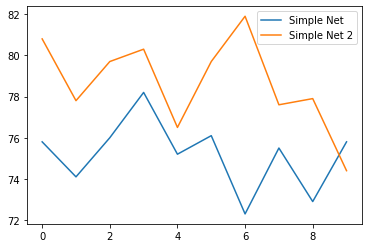

In [53]:
for result, model_params in results:
    plt.plot(result, label = model_params[0])
    plt.legend()
    
plt.show()

In [ ]:
################################ CHOICE OF THE MODEL ################################################ 

auxiliary      = False
weight_sharing = False


if (not auxiliary) and (not weight_sharing):  # model will be
    md = 'Simple Net'
    build_model = model_0                        # MLP
    #build_model = model_1                       # simple CNN
    #build_model = model_2                       # complex CNN
    

if auxiliary:                                 # model will be 
    md = 'Auxiliary Loss'  
    build_model = model_auxiliary_loss           # CNN with intermediate output for auxiliary loss
                                                 # (useful for deep NN)   

if weight_sharing:                            # model will be
    md = 'Weight Sharing'
    build_model = model_weight_sharing            # identical and independant treatment of each image  
    
    
if (auxiliary and weight_sharing):            # model will be  
    md = 'Auxiliary Loss + Weight Sharing'
    build_model = model_weight_sharing_with_auxiliary_loss    # identical and independant treatment of each image  
                                                              # with intermediate output of digit prediction 
                                                              # for auxiliary losses (per digit)